# Analysis

This notebook creates features from raw tables, runs multiple regressions and visualizes the results.

## 1. Set environment

Import libraries

In [2]:
import numpy as np
import pandas as pd
from math import floor
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from wordcloud import WordCloud, STOPWORDS
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import statsmodels.api as sm
from isodate import parse_duration
from scipy.stats import ttest_ind
from stargazer.stargazer import Stargazer

# Constantly changing
from disco import cv_bandwidth

The following cell parses json files. Avoid running it again.

Counts:
- All videos
    - 1,928
- All videos with at least one comment in first 12 hours
    - 1,846
- All videos with at least one comment in English in first 12 hours
    - 1,814
- All videos with at least one comment in first 12 hours and excluding fuzzy window
    - 1516
- All videos with at least one comment in English in first 12 hours excluding fuzzy window
    - 1504
- All comments
    - 1,197,454

Read datasets

In [3]:
# Video details table
d1 = pd.read_csv('../../dat/videoDetails.csv')

# Classified comments
# d2 = pd.read_csv('../../dat/videoFlags.csv') # Deprecated (no langid filter & no Nov-10 data)
# d2 = pd.read_csv('../../dat/videoFlagsFuzzy.csv') # Deprecated (no langid filter)
d2 = pd.read_csv('../../dat/videoFlagsFuzzyLangid.csv') # Current (has langid filter and Nov-10 data)

# Create dataframe for analysis
df = pd.merge(d1, d2, on='videoId', how='right')

Create masks for each time window

In [4]:
# Convert publishedAt to timestamp
df['publishedAt'] = pd.to_datetime(df['publishedAt'], format='%Y-%m-%dT%H:%M:%SZ')

# Sort data by upload date
df = df.sort_values('publishedAt', ascending=True).reset_index(drop=True)

# Start of policy rollout (Nov 10)
start = pd.Timestamp('2021-11-10 00:00:00')

# Start of post period (Nov 11)
post = pd.Timestamp('2021-11-11 00:00:00')

# Time windows
hours = np.arange(12, 72+1, 12)         # [12, 24, ..., 72]
windows = [f'Post{h}' for h in hours]   # [Post12, Post24, ..., Post72]

# Init dict in which to store masks
donuts = {}


# Create masks for each time window
for h in hours:

    # Set max time of upload before treatment
    lim = start - pd.Timedelta(hours=h)

    # Pre-treatment or post-treatment mask (h: mask)
    donuts[h] = df['publishedAt'].le(lim) | df['publishedAt'].ge(post)

## 2. Feature engineering
Turn `definition` to dummy

In [5]:
df['definition'] = df['definition'].replace({'sd':'0','hd':'1'}).astype(int)

Create means from counters

In [6]:
# Create per-video means
for h in hours:

    # NCRs
    df[f'ncr1Post{h}'] = df[f'post{h}CommentsNeg1'] / df[f'post{h}CommentsNum'].replace(0, 1)
    df[f'ncr2Post{h}'] = df[f'post{h}CommentsNeg2'] / df[f'post{h}CommentsNum'].replace(0, 1)
    
    # PCRs
    df[f'pcr1Post{h}'] = df[f'post{h}CommentsPos1'] / df[f'post{h}CommentsNum'].replace(0, 1)
    df[f'pcr2Post{h}'] = df[f'post{h}CommentsPos2'] / df[f'post{h}CommentsNum'].replace(0, 1)
    
    # Relative ratios (constraint: at least one of each)
    df[f'rel1Post{h}'] = np.where(
        df[f'post{h}CommentsNeg1'].gt(0) & df[f'post{h}CommentsPos1'].gt(0),
        df[f'post{h}CommentsNeg1'] / df[f'post{h}CommentsPos1'],
        np.nan
    )
    df[f'rel2Post{h}'] = np.where(
        df[f'post{h}CommentsNeg2'].gt(0) & df[f'post{h}CommentsPos2'].gt(0),
        df[f'post{h}CommentsNeg2'] / df[f'post{h}CommentsPos2'],
        np.nan
    )

Analyze most important words in video titles to create dummy variables

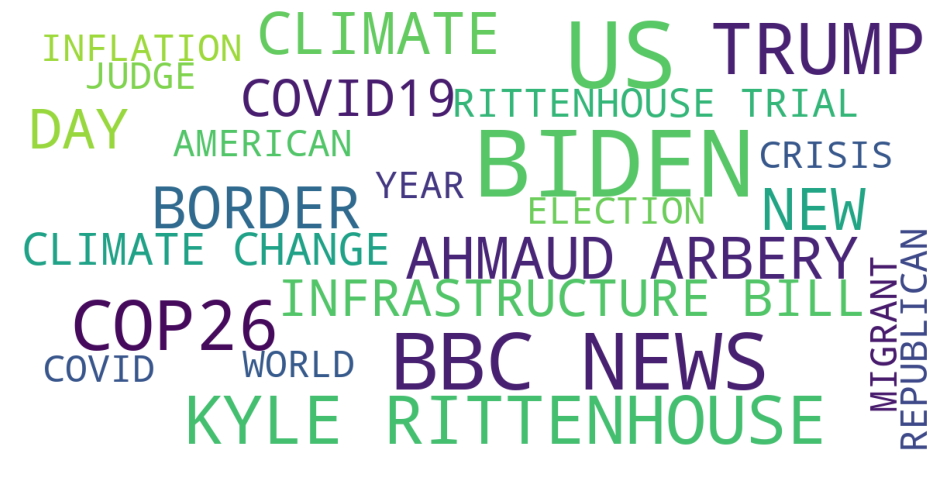

In [7]:
# All titles to single text
text = ' '.join(df['title'].str.title().tolist())

# Remove annoying strings
for string in ["'s",".","-"]:
    text = text.replace(string, '')

# All words to uppercase
text = text.upper()

# Stopwords
stopwords = set(list(STOPWORDS) + ['SAY','SAYS','S'])

# Plot wordcloud
wordcloud = WordCloud(
    background_color='white',
    max_words=25,
    stopwords=stopwords,
    max_font_size=40, 
    scale=3,
    random_state=42
).generate(text)

# Show wordcloud
fig = plt.figure(figsize=(12, 12))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

Create dummy variables by topic

In [8]:
# Title to lowercase
df['title'] = df['title'].str.lower()

# Dictionary of keywords
topics = {
    'biden':'biden',
    'trump':'trump',
    'president':'biden|trump',
    'climate':'cop26|cop 26|climate',
    'economy':'inflation|infrastructure|bill|economy',
    'covid':'covid|covid19|covid-19|virus',
    'violence':'kill|murder|assassins| die|dead|shoot|shot'
}

# Create Indicator variables
for topic in topics.keys():
    df[topic] = np.where(df['title'].str.contains(topics[topic]), 1, 0)

Video title sentiment

In [9]:
clf = SentimentIntensityAnalyzer()
df['toneCom'] = df['title'].apply(lambda x: clf.polarity_scores(x)['compound'])
df['tonePos'] = df['title'].apply(lambda x: clf.polarity_scores(x)['pos'])
df['toneNeg'] = df['title'].apply(lambda x: clf.polarity_scores(x)['neg'])

Translate `duration` to seconds.

In [10]:
# YT-duration format to seconds
df['seconds'] = df['duration'].apply(lambda x: int(parse_duration(x).total_seconds()))

# log(seconds)
df['logSeconds'] = np.log(df['seconds'])

Treatment indicator

In [11]:
df['treat'] = df['publishedAt'].ge(start).astype(int)

Declare running variable $R_i$ and interaction term $R_i \times T_i$

In [12]:
# Running variable
df['r'] = (df['publishedAt'] - start).dt.total_seconds()

# Interaction
df['rTreat'] = df['r'].multiply(df['treat'])

## 3. Descriptive Statistics

### Counts

Number of available videos as a function of $h$

In [17]:
# Init list
d = []

# Iterate over time windows
for h in hours:

    # Append case, before, after and total
    d.append(
        [
            h,
            (df['publishedAt'].le(start - pd.Timedelta(hours=h)) & df[f'post{h}CommentsNum'].gt(0)).sum(),
            (df['publishedAt'].ge(post + pd.Timedelta(hours=24)) & df[f'post{h}CommentsNum'].gt(0)).sum(),
            (donuts[h] & df[f'post{h}CommentsNum'].gt(0)).sum()
        ]
    )

# To dataframe
d = pd.DataFrame(data=d, columns=['h', 'Before', 'After', 'Total'])

# View
d
# print(
#     d.to_latex(
#         caption='Number of available videos',
#         label='tab_dat_nObs',
#         index=False
#     )
# )

,Case,Before,After,Total
0,h = 12,666,625,1504
1,h = 24,574,627,1415
2,h = 36,456,627,1298
3,h = 48,423,627,1265
4,h = 60,342,627,1184
5,h = 72,318,627,1160


### Balance tests

Balance table using a linear stepwise design and excluding the donut hole for $h = 12$.

$$X_i = \gamma_0 + \gamma_1 r_i + \gamma_2 T_i + \gamma_3 (r_i \times T_i) + V_i$$

In [ ]:
# Mask to avoid overlap with November 10 (h = 12)
mask = donuts[12] & df['post12CommentsNum'].gt(0)
print(f'{mask.sum()} videos used in balance test.')

# Copy data
d = df[mask].copy()

# Create video length (minutes)
d['durationMins'] = d['seconds'].div(60)

# Order frequent-word variables by frequency
X = list(topics.keys()) + ['definition','durationMins','tonePos','toneNeg','toneCom']

# Regress each variable on r and treat
data = []
for x in X:
    m = sm.OLS.from_formula(
        data=d,
        formula=f'{x} ~ r + treat + I(r*treat)',
    ).fit(cov_type='HC0')
    data.append((m.params['treat'], m.pvalues['treat']))

# Summary table
t = pd.DataFrame(data=data, index=X, columns=['Estimated Value','p-value'])
t.index.rename('Covariate', inplace=True)
t.reset_index(inplace=True)

# Print exog that did not pass balance test
print('Variables that did not pass: \n', t.loc[t['p-value'].lt(0.1), 'Covariate'], sep='')

# View
t.round(3)

# To latex
# print(
#     t.to_latex(
#         caption='Regression discontinuities on observable characteristics',
#         label='tab_dat_balance',
#         float_format='%.3f',
#         index=False
#     )
# )

## 4. Regression Analysis

Convenience functions

In [ ]:
# Stars function
def stars(pval):
    if pval <= 0.01:
        return '***'
    elif pval <= 0.05:
        return '**'
    elif pval <= 0.1:
        return '*'
    else:
        return ''

# Function to extract most relevant info from RDD
def get_info(models, dep_vars, hours):

    # Form dataframe
    t =  pd.DataFrame(
        {
            # Targets
            'y':np.repeat(dep_vars, len(hours)),
            # Time windows
            'h':list(hours)*len(dep_vars),
            # Betas
            'T':[models[i].params['treat'] for i in range(len(models))],
            # Standard errors
            'se':[models[i].bse['treat'] for i in range(len(models))],
            # p-values
            'pval':[models[i].pvalues['treat'] for i in range(len(models))],
            # Significance
            'signif':[stars(models[i].pvalues['treat']) for i in range(len(models))],
            # Mean at r=0
            'mean':[models[i].predict({'r':0, 'treat':0}).item() for i in range(len(models))],
            # R2
            'R2':[models[i].rsquared for i in range(len(models))],
            # Number of observations
            'nobs':[int(models[i].nobs) for i in range(len(models))]
        }
    )

    # Reindex table
    return t.set_index(['y', 'h'])

### 4.1. Fit models
The following models consider a donut hole as a funtion of $h$.

`d1:` $Y_i = \beta_0 + \beta_1 r_i + \beta_2 T_i + \beta_3 (T_i \times r_i) + U_i$

`d2:` $Y_i = \beta_0 + \beta_1 r_i + \beta_2 r_i^2 + \beta_3 T_i + \beta_4 (T_i \times r_i) + \beta_5 (T_i \times r_i)^2 + V_i$

In [ ]:
# Rename post{H}CommentsNum to make it compatible
for col in df.columns:
    if 'CommentsNum' in col:
        df.rename(
            columns={col:f'commentsNum{col[:6].title()}'},
            inplace=True
        )

# Minimum number of comments in each video
min_comments = 0

# Empty lists to store results in
d1, d2 = [], []

# Iterate over targets
for target in ['ncr1', 'ncr2', 'pcr1', 'pcr2', 'rel1', 'rel2', 'commentsNum']:

    # Iterate over Post%H windows
    for h, post in zip(hours, windows):

        # Masks for `rel1` & `rel2`
        if 'rel' in target:
            mask = donuts[h] & df[f'{target}{post}'].notna()
        
        # Masks for `ncr`, `pcr` and `commentsNum`
        else:
            mask = donuts[h] & df[f'commentsNum{post}'].gt(min_comments)

        # Linear and quad formulas for post{h}CommentsNum
        p1 = f'{target}{post} ~ treat + r + I(r*treat)'
        p2 = f'{target}{post} ~ treat + r + I(r**2) + I(r*treat) + I((r*treat)**2)'

        # Fit models
        m1 = sm.OLS.from_formula(formula=p1, data=df[mask]).fit(cov_type='HC0')
        m2 = sm.OLS.from_formula(formula=p2, data=df[mask]).fit(cov_type='HC0')

        # Append to list
        d1.append(m1)
        d2.append(m2)

# Create summary tables
d1Res = get_info(d1, ['ncr1', 'ncr2', 'pcr1', 'pcr2', 'rel1', 'rel2', 'commentsNum'], hours)
d2Res = get_info(d2, ['ncr1', 'ncr2', 'pcr1', 'pcr2', 'rel1', 'rel2', 'commentsNum'], hours)

View results from linear models

In [ ]:
# View results
d1Res.round(3)

View results from quadratic models

In [ ]:
# View
d2Res.round(3)

### 4.2. Robustness checks

#### 4.2.1. Fit linear models without donut hole
Ignore donut holes and consider treatment at `2021-11-10 00:00:00`

In [ ]:
# Empty lists to store results in
r1 = []

# Iterate over targets
for target in ['ncr1', 'ncr2', 'pcr1', 'pcr2', 'rel1', 'rel2','commentsNum']:

    # Iterate over Post%H windows
    for h, post in zip(hours, windows):

        # Mask commentsNumPost{h} > 0)
        mask = df[f'commentsNum{post}'] > 0

        # Formula for first-degree polynomial
        p1 = f'{target}{post} ~ treat + r + I(r*treat)'

        # Fit models
        m1 = sm.OLS.from_formula(formula=p1, data=df[mask]).fit(cov_type='HC0')

        # Append to list
        r1.append(m1)

# Get results
r1Res = get_info(r1, ['ncr1', 'ncr2', 'pcr1', 'pcr2', 'rel1', 'rel2', 'commentsNum'], hours)

# View results
r1Res.round(3)

#### 4.2.2. Linear models with optimum bandwidth
Find MSE-optimal bandwidth using cross-validation

In [ ]:
# Init list to store results from CVs in
cvs = []

# Iterate over targets
for target in ['ncr1', 'ncr2']:

    # Iterate over time windows
    for hour in hours:

        # Custom bandwidths for each time period (plus some pad)
        pad = 6
        bws = [(60**2)*h for h in np.arange(-144, 144+1) if abs(h) >= max(abs(hour), 24)+pad]

        # Data that excludes donut hole
        t = df[donuts[hour] & df[f'commentsNumPost{hour}'].gt(min_comments)].copy()

        # CV process
        cv = cv_bandwidth(
            data=t,
            dependent_variable=f'{target}Post{hour}',
            running_variable='r',
            cutoff=0,
            treated='above',
            degree=1,
            bandwidths=bws,
            folds=5,
            criteria='mse',
            random_state=42
        )

        # Sort by MSE DESC
        cv.sort_values('cvScore', ascending=False, inplace=True)

        # Convert bounds to hours
        cv[['lowerBoundH', 'upperBoundH']] = cv[['lowerBound', 'upperBound']].div(60**2).astype(int)

        # Add window column
        cv['window'] = hour

        # Append to list
        cvs.append(cv)

# Best bw for each target & window
opt_ncr1 = pd.concat(
    [cvs[i].head(1) for i in range(len(cvs)) if i < 6]
)
opt_ncr2 = pd.concat(
    [cvs[i].head(1) for i in range(len(cvs)) if i >= 6]
)

$NCR$ winners

In [ ]:
opt_ncr1

$sNCR$ winners

In [ ]:
opt_ncr2

Train model with optimal bandwidths

In [ ]:
# Init list to store models in
m_opt = []

# Iterate over targets
for opt, target in [(opt_ncr1, 'ncr1'), (opt_ncr2, 'ncr2')]:

    # Iterate over hours
    for i, hour in enumerate(hours):

        # Optimum bounds
        lb = opt.iloc[i, 0].item()
        ub = opt.iloc[i, 1].item()

        # Mask
        mask = donuts[hour] & df['r'].between(lb, ub)

        # Fit models
        m = sm.OLS.from_formula(
            formula=f'{target}Post{hour} ~ treat + r + rTreat',
            data=df[mask]
        ).fit(cov_type='HC0')

        # Append model to list
        m_opt.append(m)

In [ ]:
# Init list
d = []

# Extract results from each winning model
for i in range(len(m_opt)):
    d.append(
        [
            m_opt[i].params['treat'],
            m_opt[i].bse['treat'],
            m_opt[i].pvalues['treat'],
            stars(
                m_opt[i].pvalues['treat']
            ),
            m_opt[i].predict(
                {'treat':0, 'r':0, 'rTreat':0}
            ).item(),
            m_opt[i].rsquared,
            int(m_opt[i].nobs)
        ]
    )

# Results to dataframe
d = pd.DataFrame(data=d, columns=['T', 'se', 'pval', 'signif', 'mean', 'R2', 'nobs'])

# View results
d.round(3)

#### 4.2.3. Fake cutoffs

Assume fake cutoffs $\{-48, -36, -24, -12, 0, 12, 24, 36, 48\}$

In [ ]:
# Convert targets to readable titles
depvar = {'ncr1': 'NCR', 'ncr2': 'sNCR'}

# Init list to store shifts in
shifted = []

# Iterate over targets
for target in ['ncr1', 'ncr2']:

    # Iterate over time windows
    for h in hours:

        # Iterate over shifts
        for s in np.arange(-48, 48+1, 12):

            # Copy data (after dropping videos with no comments)
            d = df.loc[
                df[f'commentsNumPost{h}'].gt(min_comments),
                [f'{target}Post{h}', 'r']
            ].copy()
    
            # Shift running variable and assign treatment
            d['r'] = d['r'].add(s*60**2)
            d['treat'] = np.where(d['r'] >= 0, 1, 0)

            # Remove donut hole
            d = d[d['r'].le(-h*60**2) | d['r'].ge(24*60**2)]

            # Only continue if there's data on both sides of 0
            if (d['r'].lt(0).sum() > 0) & (d['r'].gt(0).sum() > 0):

                # Fit model
                m = sm.OLS.from_formula(
                    formula=f'{target}Post{h} ~ treat + r + I(r*treat)',
                    data=d
                ).fit(cov_type='HC0')

                # Append results
                shifted.append(
                    [
                        f'{depvar[target]} (h = {h})',
                        s,
                        m.params['treat'],
                        m.bse['treat'],
                        m.pvalues['treat'],
                        stars(m.pvalues['treat'])
                    ]
                )
            
            # Prompt skipped cases
            else:
                print(f'Skipped {target}Post{h} with shift = {s}')

# Results to dataframe
shifted = pd.DataFrame(
    data=shifted,
    columns=['Case', 'Shift', 'LATE', 'SE', 'p-value', 'Significance']
)

$NCR$ placebo results

In [ ]:
shifted[shifted['Case'].eq('NCR (h = 12)')]

In [ ]:
shifted[shifted['Case'].eq('NCR (h = 24)')]

In [ ]:
shifted[shifted['Case'].eq('NCR (h = 36)')]

In [ ]:
shifted[shifted['Case'].eq('NCR (h = 48)')]

### 4.4. Visualizations
Create dataframe with predictions from models

In [ ]:
# Init data
d = pd.DataFrame({'r':np.arange(-5*24*60**2, 5*24*60**2, 60**2)})

# Assign treatment
d['treat'] = np.where(d['r'].le(0), 0, 1)

# Init index counter
i = 0

# Iterate over targets
for target in ['ncr1', 'ncr2', 'pcr1', 'pcr2', 'rel1', 'rel2']:

    # Iterate over Post%H windows
    for h, post in zip(hours, windows):

        # Select model
        model = d1[i]

        # Init empty list
        preds = []

        # Make predictions
        for idx, vals in d.iterrows():
            pred = model.predict({'r':vals['r'], 'treat':vals['treat']})
            preds.append(pred.item())

        # Add predictions to dataframe
        d[f'{target}{post}'] = preds

        # Add 1 to counter
        i += 1

Create plots for `ncr1` models

In [ ]:
# Target name
target = 'ncr1'

# Init figure
fig, axs = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True)
fig.set_figheight(8)
fig.set_figwidth(8)

# Iterate over hours
for i, h in enumerate(hours):

    # Flatten axes
    ax = axs.flatten()[i]

    # Masks
    pre = d['r'].le(-h*60**2)
    pre_hat = d['r'].between(-h*60**2, 0)
    post_hat = d['r'].between(60**2, 24*60**2)
    post = d['r'].ge(24*60**2)

    # Predicted lines
    ax.plot(d.loc[pre, 'r'], d.loc[pre, f'{target}Post{h}'], color='C0')
    ax.plot(d.loc[pre_hat, 'r'], d.loc[pre_hat, f'{target}Post{h}'], color='C1', ls='--')
    ax.plot(d.loc[post_hat, 'r'], d.loc[post_hat, f'{target}Post{h}'], color='C1', ls='--')
    ax.plot(d.loc[post, 'r'], d.loc[post, f'{target}Post{h}'], color='C0')

    # Shaded regions
    ax.axvspan(xmin=-h*60**2, xmax=0, color='C0', alpha=0.5)
    ax.axvspan(xmin=0, xmax=24*60**2, color='gray', alpha=0.5)
    
    # Aesthetics
    ax.set_title(f'First {h} hours', fontsize=10)
    ax.set_xticks(np.linspace(-5*24*60**2, 5*24*60**2+1, 11))
    ax.set_xticklabels(np.arange(-5, 5+1))
    if i > 3:
        ax.set_xlabel('Days since November 10')
    if i % 2 == 0:
        ax.set_ylabel('NCR')

    # Get grouped means from targets
    t = df[~df['r'].between(-h*60**2, 24*60**2)].copy()
    t['bins'] = pd.qcut(t['r'], 35)
    x = t.groupby('bins')[f'{target}Post{h}'].mean()
    
    # Plot bins from targets
    ax.scatter(
        [val.left for val in x.index.values],
        x.values,
        color='C4',
        alpha=0.5,
        s=15
    )

ax.set_ylim(0, 0.8)
plt.show()

Create plots for `ncr2` models

In [ ]:
# Target name
target = 'ncr2'

# Init figure
fig, axs = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True)
fig.set_figheight(8)
fig.set_figwidth(8)

# Iterate over hours
for i, h in enumerate(hours):

    # Flatten axes
    ax = axs.flatten()[i]

    # Masks
    pre = d['r'].le(-h*60**2)
    pre_hat = d['r'].between(-h*60**2, 0)
    post_hat = d['r'].between(60**2, 24*60**2)
    post = d['r'].ge(24*60**2)

    # Predicted lines
    ax.plot(d.loc[pre, 'r'], d.loc[pre, f'{target}Post{h}'], color='C0')
    ax.plot(d.loc[pre_hat, 'r'], d.loc[pre_hat, f'{target}Post{h}'], color='C1', ls='--')
    ax.plot(d.loc[post_hat, 'r'], d.loc[post_hat, f'{target}Post{h}'], color='C1', ls='--')
    ax.plot(d.loc[post, 'r'], d.loc[post, f'{target}Post{h}'], color='C0')

    # Shaded regions
    ax.axvspan(xmin=-h*60**2, xmax=0, color='C0', alpha=0.5)
    ax.axvspan(xmin=0, xmax=24*60**2, color='gray', alpha=0.5)
    
    # Aesthetics
    ax.set_title(f'First {h} hours', fontsize=10)
    ax.set_xticks(np.linspace(-5*24*60**2, 5*24*60**2+1, 11))
    ax.set_xticklabels(np.arange(-5, 5+1))
    if i > 3:
        ax.set_xlabel('Days since November 10')
    if i % 2 == 0:
        ax.set_ylabel('sNCR')

    # Get grouped means from targets
    t = df[~df['r'].between(-h*60**2, 24*60**2)].copy()
    t['bins'] = pd.qcut(t['r'], 35)
    x = t.groupby('bins')[f'{target}Post{h}'].mean()
    
    # Plot bins from targets
    ax.scatter(
        [val.left for val in x.index.values],
        x.values,
        color='C4',
        alpha=0.5,
        s=15
    )

ax.set_ylim(0, 0.8)
plt.show()